In [32]:
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from PIL import Image

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
from random import choice
from skimage import io
import sklearn.metrics

from tqdm.notebook import tqdm

In [33]:
class CFG:
    BATCH_SIZE = 64
    EPOCHS = 100
    LEARNING_RATE = 3e-4

In [34]:
TRAIN_PATH = './train/train/'
TEST_PATH = './test/'
sample_csv = pd.read_csv('./sample_submission.csv')
test_csv = pd.read_csv('./test.csv')

In [4]:
lst = os.listdir(TRAIN_PATH+'Post')
filenames = [file[5:] for file in lst]
print(len(filenames))

1000


In [5]:
class Custom_Dataset(Dataset):
   
    def __init__(self, TRAIN_PATH, filenames, transform=None):
        
        self.filenames = filenames
        self.post_op_path = TRAIN_PATH + "Post/"
        self.pre_op_path = TRAIN_PATH + "Pre/" 
        self.transform = transform
        df_columns = ['post_name', 'pre_name', 'label']
        self.df = pd.DataFrame(columns=df_columns)
        
        for i in range(len(filenames)):
            label = 1
            post_fn = "POST_"+filenames[i]
            pre_fn_true = "PRE_"+filenames[i]
            self.df = self.df.append(pd.Series([post_fn, pre_fn_true, label], index=self.df.columns), ignore_index=True)

            label=0
            rand_idx = choice([j for j in range(len(filenames)) if j not in [i]])
            pre_fn_false = "PRE_"+filenames[rand_idx]
            self.df = self.df.append(pd.Series([post_fn, pre_fn_false, label], index=self.df.columns), ignore_index=True)
            
        
    def __len__(self):
        return len(self.df)
    
    
    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        post_name = row['post_name']
        pre_name = row['pre_name']
        label = row['label']
        
        post_img = Image.fromarray(io.imread(self.post_op_path+post_name))
        pre_img = Image.fromarray(io.imread(self.pre_op_path+pre_name))
        
#         post_img = Image.fromarray(post_img.transpose(2,0,1))
#         pre_img = Image.fromarray(pre_img.transpose(2,0,1))        
#         post_img = np.array(Image.open(self.post_op_path+post_name),
#         pre_img = Image.open(self.pre_op_path+pre_name) 
        
        if self.transform:
#             print(type(post_img))
            post_img = self.transform(post_img)
            pre_img = self.transform(pre_img)
        
        return post_img, pre_img, label

01e2cc7b8ec040b2bc5794d55f9a8532.jpg 7b7f6b3374f2479991aa8fce3c664932.jpg


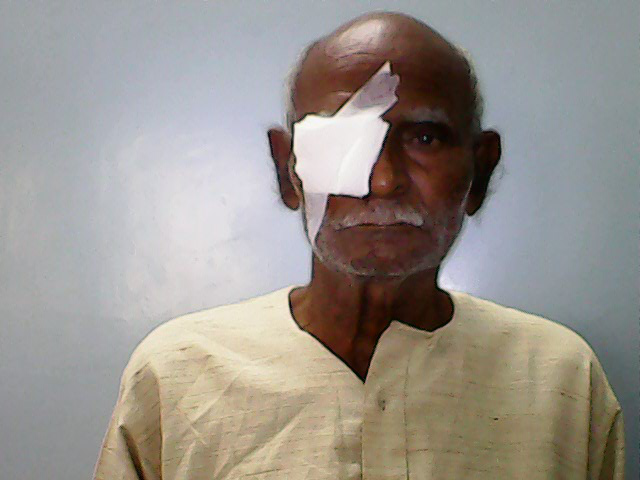

In [6]:
img1, img2 = test_csv.iloc[0].item().split(',')
img1 = img1.strip()
img2 = img2.strip()

print(img1, img2)
img1 = Image.fromarray(io.imread(TEST_PATH+img1))
img1

In [7]:
class Test_Dataset(Dataset):
   
    def __init__(self, TEST_PATH, test_csv, transform=None):
        
        self.img_path = TEST_PATH
        self.transform = transform
        
    def __len__(self):
        return len(test_csv)
    
    
    def __getitem__(self, idx):
        img1_name, img2_name = test_csv.iloc[idx].item().split(',')
        img1_name = img1_name.strip()
        img2_name = img2_name.strip()
        
        img1 = Image.fromarray(io.imread(self.img_path+img1_name))
        img2 = Image.fromarray(io.imread(self.img_path+img2_name))
        
        if self.transform:
#             print(type(post_img))
            img1 = self.transform(img1)
            img2 = self.transform(img2)
        
        return img1, img2

In [8]:
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

train_size = 90
train_size = int((80/100) * len(filenames))
train_dataset = Custom_Dataset(TRAIN_PATH, filenames[:train_size], transform=transform)
train_dataloader = DataLoader(train_dataset, batch_size=CFG.BATCH_SIZE, shuffle=True)

val_dataset = Custom_Dataset(TRAIN_PATH, filenames[train_size:], transform=transform)
val_dataloader = DataLoader(val_dataset, batch_size=CFG.BATCH_SIZE*2, shuffle=False)

In [9]:
test_transform = transforms.Compose([
    transforms.Resize((224,224)),
#     transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])
])

test_dataset = Test_Dataset(TEST_PATH, test_csv, transform=test_transform)
test_dataloader = DataLoader(test_dataset, batch_size=CFG.BATCH_SIZE*2, shuffle=False)

torch.Size([128, 3, 224, 224])


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping i

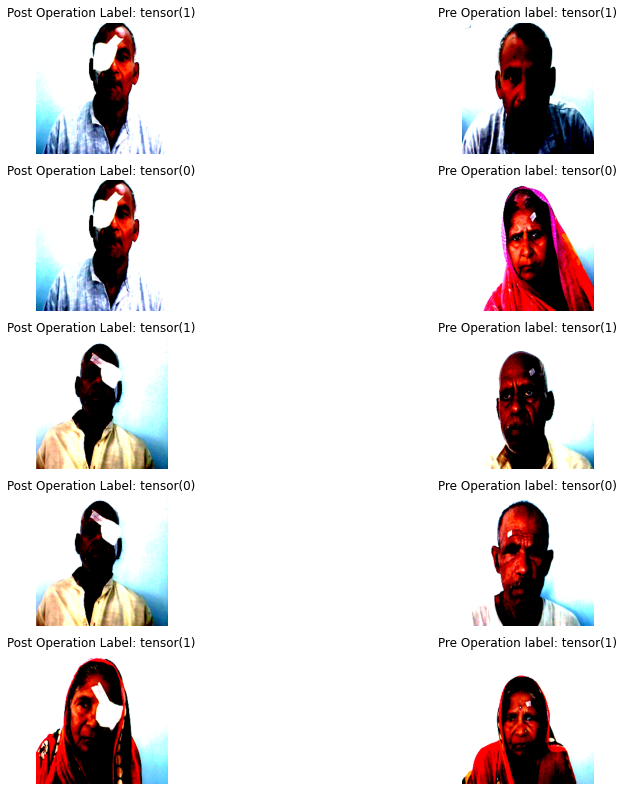

In [10]:
post_img, pre_img, label = next(iter(val_dataloader))
print(post_img.shape)
post_img = post_img.numpy()
pre_img = pre_img.numpy()
show = 5


fig, ax = plt.subplots(5, 2, figsize=(14,14))
for i in range(5):
    ax[i][0].imshow(post_img[i].transpose(1,2,0))
    ax[i][0].set_title('Post Operation Label: '+str(label[i]))
    ax[i][0].axis('off')

    ax[i][1].imshow(pre_img[i].transpose(1,2,0))
    ax[i][1].set_title('Pre Operation label: '+str(label[i]))
    ax[i][1].axis('off')
    

plt.show()


In [11]:
model_up = models.mobilenet_v3_small(pretrained=True)
model_dn = models.mobilenet_v3_small(pretrained=True)

In [12]:
print(model_up)

MobileNetV3(
  (features): Sequential(
    (0): ConvBNActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): ConvBNActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
          (relu): ReLU(inplace=True)
          (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
        )
        (2): ConvBNActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_r

In [13]:
for model in [model_up, model_dn]:
    for params in model.parameters():
        params.requires_grad = False
        

print(model_up)

MobileNetV3(
  (features): Sequential(
    (0): ConvBNActivation(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
      (2): Hardswish()
    )
    (1): InvertedResidual(
      (block): Sequential(
        (0): ConvBNActivation(
          (0): Conv2d(16, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), groups=16, bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_running_stats=True)
          (2): ReLU(inplace=True)
        )
        (1): SqueezeExcitation(
          (fc1): Conv2d(16, 8, kernel_size=(1, 1), stride=(1, 1))
          (relu): ReLU(inplace=True)
          (fc2): Conv2d(8, 16, kernel_size=(1, 1), stride=(1, 1))
        )
        (2): ConvBNActivation(
          (0): Conv2d(16, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(16, eps=0.001, momentum=0.01, affine=True, track_r

In [14]:
class My_Model(nn.Module):
    def __init__(self, model_up, model_dn):
        super().__init__()
        self.model_up = model_up
        self.model_dn = model_dn
        self.linear0 = nn.Linear(2000, 512)
        self.linear1 = nn.Linear(512, 512)
        self.linear2 = nn.Linear(512, 2)
        self.softmax = nn.Softmax(dim=1)
        self.dropout = nn.Dropout()
        self.relu = nn.ReLU()
        
    def forward(self, post_img, pre_img):
        final_up = self.model_up(post_img)
#         print('final_up : ', final_up.shape)
        final_dn = self.model_dn(pre_img)   
#         print('final_dn : ', final_dn.shape)
        
        x = torch.cat((final_up, final_dn),1)
#         print(x.shape)
        x = self.relu(self.linear0(x))
        x = self.relu(self.linear1(x))
#        x = self.dropout(x)
        x = self.linear2(x)
        x = self.softmax(x)
        return x
        

In [15]:
model = My_Model(model_up, model_dn)
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
model = model.to(device)

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=CFG.LEARNING_RATE)

def train(model, optimizer, criterion):
    train_loss = []
    eval_loss = []
    macro_f1 = []
    val_macro_f1 = []
    for epoch in tqdm(range(CFG.EPOCHS)):
        train_loss_per_epoch = 0
        model.train()
        true_labels = []
        pred_labels = []
        
        for post_img, pre_img, labels in train_dataloader:
            post_img = post_img.to(device)
            pre_img = pre_img.to(device)
            labels = labels.to(device)
            out = model(post_img, pre_img)
            _, pred = torch.max(out, axis=1)
            
            loss = criterion(out, labels)

            train_loss_per_epoch += loss.item() / len(train_dataloader)
            
            true_labels.append(labels.cpu().numpy())
            pred_labels.append(pred.cpu().numpy())
            
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()
            
        train_loss.append(train_loss_per_epoch)
        model.eval()
        val_true_labels = []
        val_pred_labels = []
        with torch.no_grad():
            val_loss_per_epoch = 0
            for post_img, pre_img, labels in val_dataloader:
                post_img = post_img.to(device)
                pre_img = pre_img.to(device)
                labels = labels.to(device)
                out = model(post_img, pre_img)
                _, pred = torch.max(out, axis=1)
                loss = criterion(out, labels)
                val_true_labels.append(labels.cpu().numpy())
                val_pred_labels.append(pred.cpu().numpy())
                
                val_loss_per_epoch += loss.item() / len(val_dataloader)
                
        eval_loss.append(val_loss_per_epoch)
        
        true_labels = np.concatenate(true_labels)
        pred_labels = np.concatenate(pred_labels) 
        val_true_labels = np.concatenate(val_true_labels)
        val_pred_labels = np.concatenate(val_pred_labels)
        macro_f1_per_epoch = sklearn.metrics.f1_score(true_labels, pred_labels)
        macro_f1.append(macro_f1_per_epoch)
        val_macro_f1_per_epoch = sklearn.metrics.f1_score(val_true_labels, val_pred_labels)
        val_macro_f1.append(val_macro_f1_per_epoch)
        
        print(f"EPOCH: {epoch+1}\tTRAIN_LOSS: {train_loss_per_epoch}\tVAL_LOSS: {val_loss_per_epoch}\tMACRO_F1: {macro_f1_per_epoch}\tVAL_MACRO_F1: {val_macro_f1_per_epoch}")
        
    return train_loss, eval_loss, macro_f1, val_macro_f1

In [16]:
train_loss, eval_loss, macro_f1, val_macro_f1 = train(model, optimizer, criterion)

  0%|          | 0/100 [00:00<?, ?it/s]

EPOCH: 1	TRAIN_LOSS: 0.683896722793579	VAL_LOSS: 0.6781242191791534	MACRO_F1: 0.5499689633767846	VAL_MACRO_F1: 0.38225255972696254
EPOCH: 2	TRAIN_LOSS: 0.5984748196601868	VAL_LOSS: 0.6243289858102798	MACRO_F1: 0.7229336437718278	VAL_MACRO_F1: 0.7023255813953488
EPOCH: 3	TRAIN_LOSS: 0.5454398679733276	VAL_LOSS: 0.6228661686182022	MACRO_F1: 0.7947165657677491	VAL_MACRO_F1: 0.701123595505618
EPOCH: 4	TRAIN_LOSS: 0.527515161037445	VAL_LOSS: 0.625922903418541	MACRO_F1: 0.797525309336333	VAL_MACRO_F1: 0.6456692913385828
EPOCH: 5	TRAIN_LOSS: 0.5013130390644074	VAL_LOSS: 0.5963331013917923	MACRO_F1: 0.8262108262108262	VAL_MACRO_F1: 0.7066974595842956
EPOCH: 6	TRAIN_LOSS: 0.48454790234565737	VAL_LOSS: 0.5952120274305344	MACRO_F1: 0.8385985066053991	VAL_MACRO_F1: 0.708803611738149
EPOCH: 7	TRAIN_LOSS: 0.4618870401382446	VAL_LOSS: 0.5659582614898682	MACRO_F1: 0.8695652173913043	VAL_MACRO_F1: 0.7238095238095238
EPOCH: 8	TRAIN_LOSS: 0.45567318081855773	VAL_LOSS: 0.5728719383478165	MACRO_F1: 0.85918

EPOCH: 64	TRAIN_LOSS: 0.32601894974708556	VAL_LOSS: 0.5470039546489716	MACRO_F1: 0.987546699875467	VAL_MACRO_F1: 0.7849223946784922
EPOCH: 65	TRAIN_LOSS: 0.3246355414390564	VAL_LOSS: 0.5098412930965424	MACRO_F1: 0.9900249376558605	VAL_MACRO_F1: 0.7990762124711316
EPOCH: 66	TRAIN_LOSS: 0.3245976305007934	VAL_LOSS: 0.5551560670137405	MACRO_F1: 0.9881026925485286	VAL_MACRO_F1: 0.7775377969762418
EPOCH: 67	TRAIN_LOSS: 0.32922725439071654	VAL_LOSS: 0.528564877808094	MACRO_F1: 0.9838509316770186	VAL_MACRO_F1: 0.7924528301886793
EPOCH: 68	TRAIN_LOSS: 0.32829120874404905	VAL_LOSS: 0.5475486665964127	MACRO_F1: 0.9856519026824703	VAL_MACRO_F1: 0.7886710239651418
EPOCH: 69	TRAIN_LOSS: 0.3335647332668304	VAL_LOSS: 0.5344087779521942	MACRO_F1: 0.9781386633354153	VAL_MACRO_F1: 0.7635467980295567
EPOCH: 70	TRAIN_LOSS: 0.3280398070812224	VAL_LOSS: 0.532566674053669	MACRO_F1: 0.986232790988736	VAL_MACRO_F1: 0.8079470198675497
EPOCH: 71	TRAIN_LOSS: 0.32353870630264286	VAL_LOSS: 0.5657504573464394	MACRO_

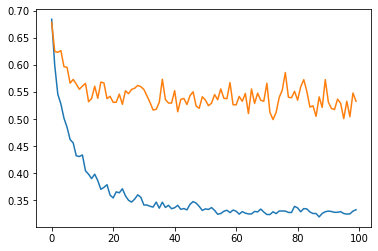

In [17]:
plt.plot(train_loss, label='Train')
plt.plot(eval_loss, label='Eval')
plt.show()

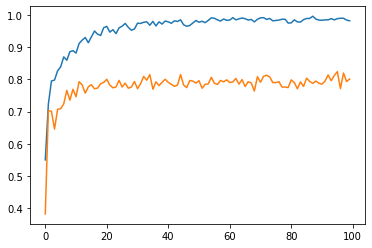

In [18]:
plt.plot(macro_f1, label='Train')
plt.plot(val_macro_f1, label='Eval')
plt.show()

In [25]:
def inference(model):
    model.eval()
    with torch.no_grad():
        predictions = []
        scores = []
        for img1, img2 in tqdm(test_dataloader):
            img1 = img1.to(device)
            img2 = img2.to(device)
            out = model(img1, img2)
            scores.append(out.cpu().numpy())
            _, pred = torch.max(out, 1)
#             print(pred.cpu().numpy())
            predictions.append(pred.cpu().numpy())

    return predictions, scores

In [26]:
predictions, scores = inference(model)

  0%|          | 0/40 [00:00<?, ?it/s]

In [27]:
test_pred = np.concatenate(predictions)
test_pred.shape

(5000,)

In [28]:
tmp = test_csv.copy()
tmp[['0','1']] = np.concatenate(scores)
tmp.to_csv('Predictions2.csv', index=False)

In [29]:
test_csv['Predicted'] = test_pred

In [30]:
test_csv.to_csv('Submissions2.csv', index=False)

In [31]:
import gc
gc.collect()

5699